# Insurance word2vec

Inspired on [Thrones2Vec](https://github.com/YuriyGuts/thrones2vec)

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

C:\Users\diogopinto\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### Set-up logging

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#### Download NLTK tokenizer models (only the first time)

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diogopinto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diogopinto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare corpus

#### Load data

In [6]:
with codecs.open('text-mining/data2.txt', 'r', 'utf-8') as f:
    articles = f.read()

In [7]:
articles[:500]

'Health Insurance: How Does It Work?\nFour Questions to Ask About Health Care Reform\nWe rarely have to ask how car insurance or home insurance work. What is it that makes health insurance so much more complicated — with individual mandates, single or multiple payers, and so on? Since Congress is (once again) talking about changing how health care works in America, it may be a good time to explain what makes it so strange. This thing we sometimes call “health insurance” is actually a fusion of thre'

#### Split the corpus into sentences

In [8]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [9]:
raw_sentences = tokenizer.tokenize(articles)

In [10]:
raw_sentences[:10]

['Health Insurance: How Does It Work?',
 'Four Questions to Ask About Health Care Reform\nWe rarely have to ask how car insurance or home insurance work.',
 'What is it that makes health insurance so much more complicated — with individual mandates, single or multiple payers, and so on?',
 'Since Congress is (once again) talking about changing how health care works in America, it may be a good time to explain what makes it so strange.',
 'This thing we sometimes call “health insurance” is actually a fusion of three different things, only one and a half of which are “insurance” at all.',
 'I’m going to walk through the basics you need to know, and end up with a set of four questions you can ask about any health care proposal that will let you understand what people are really talking about.',
 '(I’m not going to tell you what I think the right answers are, though.',
 'This article is to help you ask the right questions — and I’m interested in your answers.)',
 'Not as bad as it looks: t

In [11]:
def sentence_to_wordlist(raw):
    clean = re.sub(r'[^a-zA-Z]', " ", raw)
    words = clean.split()
    return words

In [12]:
sentences = [sentence_to_wordlist(sentence) for sentence in raw_sentences if len(sentence) > 0]

In [13]:
sentences[:2]

[['Health', 'Insurance', 'How', 'Does', 'It', 'Work'],
 ['Four',
  'Questions',
  'to',
  'Ask',
  'About',
  'Health',
  'Care',
  'Reform',
  'We',
  'rarely',
  'have',
  'to',
  'ask',
  'how',
  'car',
  'insurance',
  'or',
  'home',
  'insurance',
  'work']]

### Stop words removal

In [14]:
from nltk.corpus import stopwords

In [15]:
stop = set(stopwords.words('english'))

In [16]:
sentences_non_stop = [[word for word in sentence if word not in stop] for sentence in sentences]

### Stemmer

[TODO]

Token count

In [17]:
sum([len(sentence) for sentence in sentences_non_stop])

310542

## Train Word2Vec

In [18]:
num_features = 300 # dimensionality of the resulting word vectors
min_word_count = 3 # minimum word count threshold
num_workers = multiprocessing.cpu_count() # number of threads to run in parallel
context_size = 7 # context window length
downsampling = 1e-3 # downlsample setting for frequent words
seed = 42 # seed for the rng, to make the results reproducible

In [19]:
insurance2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [20]:
insurance2vec.build_vocab(sentences)

2017-05-16 15:19:14,676 : INFO : collecting all words and their counts
2017-05-16 15:19:14,679 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-16 15:19:14,785 : INFO : PROGRESS: at sentence #10000, processed 217616 words, keeping 15399 word types
2017-05-16 15:19:14,867 : INFO : PROGRESS: at sentence #20000, processed 463900 words, keeping 24147 word types
2017-05-16 15:19:14,880 : INFO : collected 25288 word types from a corpus of 516087 raw words and 22001 sentences
2017-05-16 15:19:14,880 : INFO : Loading a fresh vocabulary
2017-05-16 15:19:14,940 : INFO : min_count=3 retains 10946 unique words (43% of original 25288, drops 14342)
2017-05-16 15:19:14,940 : INFO : min_count=3 leaves 497688 word corpus (96% of original 516087, drops 18399)
2017-05-16 15:19:14,994 : INFO : deleting the raw counts dictionary of 25288 items
2017-05-16 15:19:14,997 : INFO : sample=0.001 downsamples 45 most-common words
2017-05-16 15:19:14,998 : INFO : downsampling leaves

Vocabulary length:

In [21]:
len(insurance2vec.wv.vocab)

10946

### Train the model

In [22]:
insurance2vec.train(sentences)

2017-05-16 15:19:15,376 : INFO : training model with 4 workers on 10946 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-05-16 15:19:15,382 : INFO : expecting 22001 sentences, matching count from corpus used for vocabulary survey
2017-05-16 15:19:16,503 : INFO : PROGRESS: at 7.14% examples, 118046 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:19:17,623 : INFO : PROGRESS: at 14.61% examples, 127169 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:19:18,685 : INFO : PROGRESS: at 22.09% examples, 132568 words/s, in_qsize 8, out_qsize 0
2017-05-16 15:19:19,745 : INFO : PROGRESS: at 30.49% examples, 135176 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:19:20,810 : INFO : PROGRESS: at 37.35% examples, 135430 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:19:21,832 : INFO : PROGRESS: at 44.82% examples, 136424 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:19:22,854 : INFO : PROGRESS: at 51.99% examples, 136059 words/s, in_qsize 7, out_qsize 0
2017-05-16 15:19

1969884

#### Save to file

In [23]:
if not os.path.exists('trained'):
    os.makedirs('trained')

In [24]:
insurance2vec.save(os.path.join('trained', 'insurance2vec.w2v'))

2017-05-16 15:19:29,820 : INFO : saving Word2Vec object under trained\insurance2vec.w2v, separately None
2017-05-16 15:19:29,828 : INFO : not storing attribute syn0norm
2017-05-16 15:19:29,831 : INFO : not storing attribute cum_table
2017-05-16 15:19:30,348 : INFO : saved trained\insurance2vec.w2v


## Explore the trained model

In [25]:
insurance2vec = w2v.Word2Vec.load(os.path.join('trained', 'insurance2vec.w2v'))

2017-05-16 15:19:30,358 : INFO : loading Word2Vec object from trained\insurance2vec.w2v
2017-05-16 15:19:30,750 : INFO : loading wv recursively from trained\insurance2vec.w2v.wv.* with mmap=None
2017-05-16 15:19:30,751 : INFO : setting ignored attribute syn0norm to None
2017-05-16 15:19:30,752 : INFO : setting ignored attribute cum_table to None
2017-05-16 15:19:30,754 : INFO : loaded trained\insurance2vec.w2v


## Compress the word vectors into 2D space

In [26]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=seed)

In [27]:
all_word_vectors_matrix = insurance2vec.wv.syn0

In [28]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

#### Plot the big picture

In [29]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[insurance2vec.wv.vocab[word].index])
            for word in insurance2vec.wv.vocab
        ]
    ],
    columns=['word', 'x', 'y']
)

In [30]:
points.head()

,word,x,y
0,Leo,-2.637159,-1.528505
1,campaigned,5.438625,-2.645405
2,defined,2.218485,2.447097
3,extending,2.239341,3.994984
4,Responds,-5.264719,1.051543


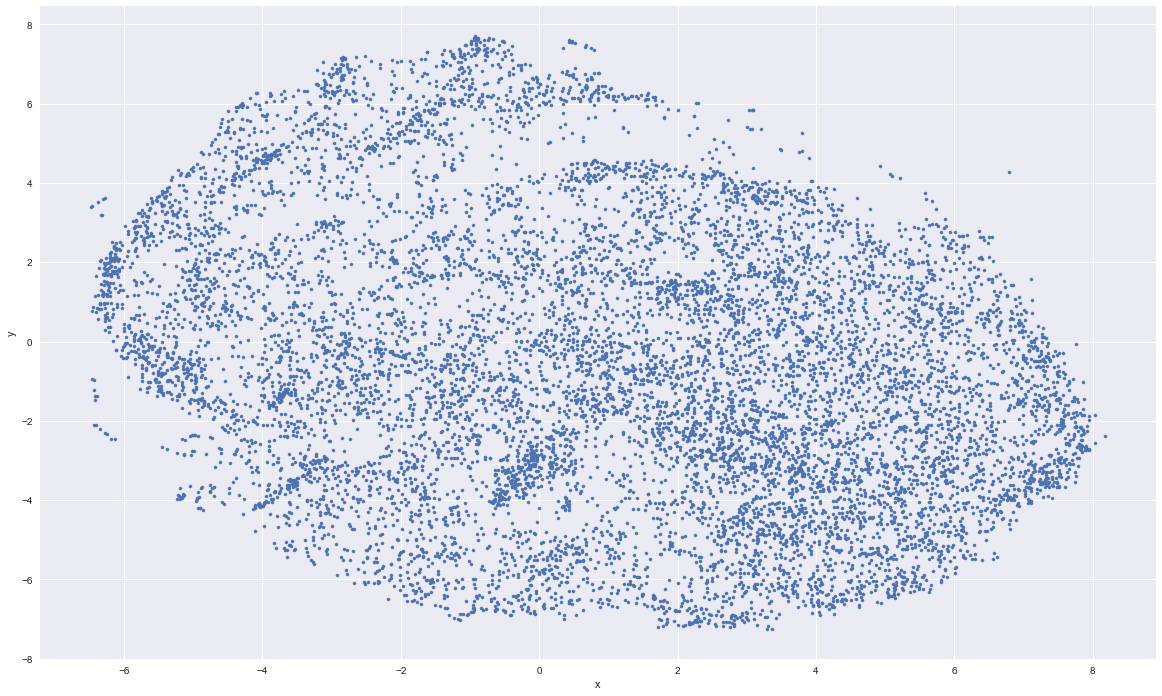

In [31]:
points.plot.scatter('x', 'y', s=10, figsize=(20, 12))

In [32]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

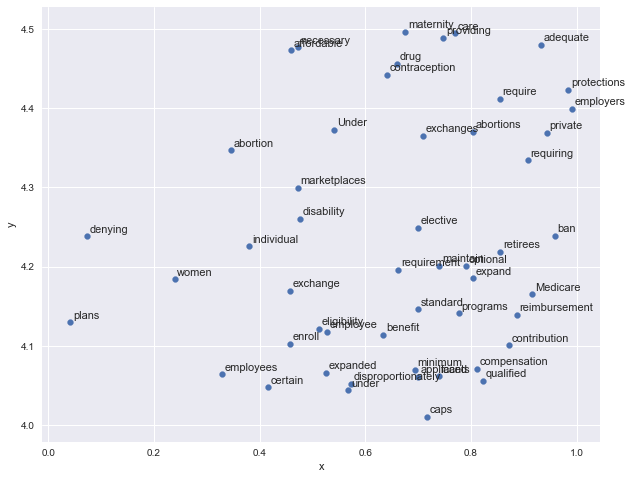

In [33]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

## Explore semantic similarities between book characters

#### Words closest to the given word

In [34]:
insurance2vec.most_similar('insurance')

2017-05-16 15:25:41,906 : INFO : precomputing L2-norms of word weight vectors


[('policies', 0.7013731002807617),
 ('brokerage', 0.6919546127319336),
 ('insurances', 0.6909133195877075),
 ('specifically', 0.6859185099601746),
 ('med', 0.6842886209487915),
 ('rental', 0.6836692690849304),
 ('warranties', 0.6812809109687805),
 ('offering', 0.6784009337425232),
 ('individual', 0.6751512885093689),
 ('shop', 0.6750141382217407)]

In [35]:
insurance2vec.most_similar('blockchain')

[('intelligence', 0.9216578602790833),
 ('development', 0.9105468392372131),
 ('centric', 0.9076791405677795),
 ('predictive', 0.9064403176307678),
 ('design', 0.8995383977890015),
 ('android', 0.8992748260498047),
 ('models', 0.8953187465667725),
 ('technologies', 0.8950081467628479),
 ('distribution', 0.8937808871269226),
 ('connected', 0.8927836418151855)]

In [36]:
insurance2vec.most_similar('broker')

[('developer', 0.9209660887718201),
 ('android', 0.9176017642021179),
 ('websites', 0.9154828786849976),
 ('online', 0.9105687141418457),
 ('dynamic', 0.9099389314651489),
 ('connect', 0.9083340764045715),
 ('reputation', 0.9082989692687988),
 ('brand', 0.9044582843780518),
 ('smartphone', 0.9001700282096863),
 ('peers', 0.8991681933403015)]

#### Linear relationships between word pairs

In [37]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = insurance2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print('{start1} is related to {end1}, as {start2} is related to {end2}'.format(**locals()))

In [38]:
nearest_similarity_cosmul('blockchain', 'bank', 'insurance')

blockchain is related to bank, as disrupt is related to insurance


In [39]:
nearest_similarity_cosmul('legacy', 'bank', 'insurance')

legacy is related to bank, as designed is related to insurance


# Develop a model for text generation

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

Using TensorFlow backend.


In [41]:
from keras.layers import Embedding
from keras.engine import Input

In [42]:
idx2word = ['null'] + list(insurance2vec.wv.vocab.keys())

In [43]:
word2idx = {w: i for i, w in enumerate(idx2word)}

In [44]:
word_vectors = np.asarray([insurance2vec.wv.word_vec(w) for w in idx2word if w != 'null'])

In [45]:
word_vectors = np.append(np.zeros((1, num_features)), word_vectors, axis=0)

In [46]:
Embedding(input_dim=word_vectors.shape[0], 
          output_dim=num_features, 
          weights=word_vectors)

In [47]:
sentences_randomized = np.random.permutation(sentences)

In [48]:
import math

In [49]:
train_test_split = math.floor(len(sentences_randomized) * 0.8)

In [50]:
x_train = np.asarray([[word2idx[word] if word in word2idx else 0 for word in sentence[:-1]] for sentence in sentences_randomized[:train_test_split]])

In [51]:
x_valid = np.asarray([[word2idx[word] if word in word2idx else 0 for word in sentence[:-1]] for sentence in sentences_randomized[train_test_split:]])

In [52]:
y_train = np.asarray([[word2idx[word] if word in word2idx else 0 for word in sentence[1:]] for sentence in sentences_randomized[:train_test_split]])

In [53]:
y_valid = np.asarray([[word2idx[word] if word in word2idx else 0 for word in sentence[1:]] for sentence in sentences_randomized[train_test_split:]])

In [54]:
max_len = 80
batch_size = 32

### Pad sequences

In [55]:
from keras.preprocessing import sequence

In [56]:
x_train = sequence.pad_sequences(x_train, maxlen=max_len)

In [57]:
y_train = sequence.pad_sequences(y_train, maxlen=max_len)

In [58]:
x_valid = sequence.pad_sequences(x_valid, maxlen=max_len)

In [208]:
y_valid = sequence.pad_sequences(y_valid, maxlen=max_len)

### Build the model

In [212]:
model = Sequential()

In [213]:
model.add(Embedding(input_dim=word_vectors.shape[0], 
          output_dim=num_features, 
          weights=[word_vectors]))

In [214]:
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

In [215]:
model.add(Dense(word_vectors.shape[0], activation='softmax'))

In [216]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [217]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_valid, y_valid))

ValueError: Error when checking model target: expected dense_1 to have shape (None, 10947) but got array with shape (17600, 80)

## Character by character model

In [63]:
articles[:100]

'Health Insurance: How Does It Work?\nFour Questions to Ask About Health Care Reform\nWe rarely have to'

In [64]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [65]:
chars = sorted(list(set(articles)))

In [68]:
idx2char = chars

In [69]:
char2idx = {c: i for i, c in enumerate(idx2char)}

In [71]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(articles) - maxlen, step):
    sentences.append(articles[i:i+maxlen])
    next_chars.append(articles[i+maxlen])

#### Vectorization

In [80]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)

In [81]:
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

In [82]:
for i, sentence in enumerate(sentences):
    for j, char in enumerate(sentence):
        x[i, j, char2idx[char]] = 1
    y[i, char2idx[next_chars[i]]] = 1

In [83]:
idx = np.random.permutation(len(x))

In [85]:
x = x[idx]

In [86]:
y = y[idx]

In [87]:
train_test_split = int(len(x) * 0.8)

In [88]:
x_train, x_valid = x[:train_test_split], x[train_test_split:]

In [89]:
y_train, y_valid = y[:train_test_split], y[train_test_split:]

## Build the model

In [107]:
model = Sequential()

In [108]:
model.add(LSTM(128, input_shape=(maxlen, len(chars))))

In [109]:
model.add(Dense(len(chars), activation='softmax'))

In [110]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [111]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)/temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [112]:
for i in range(16):
    print()
    print('-'*50)
    print("Iteration {}".format(i+1))
    model.fit(x_train, y_train,
              batch_size=128,
              epochs=1)
    
    start_index = random.randint(0, len(articles) - maxlen - 1)
    
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity: {}'.format(diversity))
        
        generated = ''
        sentence = articles[start_index:start_index + maxlen]
        generated += sentence
        print('------ Generating with seed: "{}"'.format(sentence))
        
        for j in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for k, char in enumerate(sentence):
                x[0, k, char2idx[char]] = 1.
            
            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = idx2char[next_index]
            
            generated += next_char
            sentence = sentence[1:] + next_char
        print(generated)


--------------------------------------------------
Iteration 1
Epoch 1/1
836966/836966 [==============================] - 1962s - loss: 2.3286 - acc: 0.3497  

----- diversity: 0.2
------ Generating with seed: "one-stop shopping” and service in multip"
one-stop shopping” and service in multiple insurance the deall the provers and the proved the compance the conder the conding the companies the compance the proved the and the compance the compane the complate insurance the contored the compare the provere to the companies and the were a propent in the compane the peally the companies and the and the promed the promed the has and the conder the coverage the call insurance the companies 

----- diversity: 0.5
------ Generating with seed: "one-stop shopping” and service in multip"
one-stop shopping” and service in multiplly and companie seall insurance that the prowes experticly to conds the palle and insurance the prepence that eronded the wask at of thi lack could acrestion lack to the 

In [ ]:
for i in range(16):
    print()
    print('-'*50)
    print("Iteration {}".format(i+1+16))
    model.fit(x_train, y_train,
              batch_size=128,
              epochs=1)
    
    start_index = random.randint(0, len(articles) - maxlen - 1)
    
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity: {}'.format(diversity))
        
        generated = ''
        sentence = articles[start_index:start_index + maxlen]
        generated += sentence
        print('------ Generating with seed: "{}"'.format(sentence))
        
        for j in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for k, char in enumerate(sentence):
                x[0, k, char2idx[char]] = 1.
            
            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = idx2char[next_index]
            
            generated += next_char
            sentence = sentence[1:] + next_char
        print(generated)


--------------------------------------------------
Iteration 17
Epoch 1/1
836966/836966 [==============================] - 1964s - loss: 1.4013 - acc: 0.5888  

----- diversity: 0.2
------ Generating with seed: "e giants decamp in the least regulated s"
e giants decamp in the least regulated states the company and the company and the policy and the policy and the product of the constitution of the provide of the product of the policy and the company and the product of the part of the insurance companies that was a lot of the product of the product of the product of the policy of the states of the product of the policy of the insurance product of the states of the process to be a presen

----- diversity: 0.5
------ Generating with seed: "e giants decamp in the least regulated s"
e giants decamp in the least regulated services we should be able to encourage their presents that the self-based of the paymatical insurance companies to pay for the policy of the provide of the government of 

In [ ]:
for i in range(16):
    print()
    print('-'*50)
    print("Iteration {}".format(i+1+32))
    model.fit(x_train, y_train,
              batch_size=128,
              epochs=1)
    
    start_index = random.randint(0, len(articles) - maxlen - 1)
    
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity: {}'.format(diversity))
        
        generated = ''
        sentence = articles[start_index:start_index + maxlen]
        generated += sentence
        print('------ Generating with seed: "{}"'.format(sentence))
        
        for j in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for k, char in enumerate(sentence):
                x[0, k, char2idx[char]] = 1.
            
            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = idx2char[next_index]
            
            generated += next_char
            sentence = sentence[1:] + next_char
        print(generated)